In [1]:
import time
start = time.time()

In [11]:
import onnxruntime as rt
import numpy as np
import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt
from PIL import Image

In [13]:
def resize_crop(image):
    h, w, c = np.shape(image)
    if min(h, w) > 720:
        if h > w:
            h, w = int(720*h/w), 720
        else:
            h, w = 720, int(720*w/h)
    image = cv2.resize(image, (w, h),
                       interpolation=cv2.INTER_AREA)
    h, w = (h//8)*8, (w//8)*8
    image = image[:h, :w, :]
    return image

In [14]:
def cartoonize(img, model):
    batch_image = img.astype(np.float32)/127.5 - 1
    batch_image = np.expand_dims(batch_image, axis=0)
    ort_inputs = {model.get_inputs()[0].name: batch_image}
    ort_outs = model.run(None, ort_inputs)
    img_out = ort_outs[0]
    output = (np.squeeze(img_out)+1)*127.5
    cartoon = np.clip(output, 0, 255).astype(np.uint8)
    return cartoon

In [15]:
def normalize(image):
    MEAN = 255 * np.array([0.485, 0.456, 0.406])
    STD = 255 * np.array([0.229, 0.224, 0.225])
    x = np.array(image)
    x = x.transpose(-1, 0, 1)
    x = (x - MEAN[:, None, None]) / STD[:, None, None]
    output = np.array([x.astype('float32')])
    return output

In [16]:
def findmask(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    input_image = normalize(image)
    
    ort_inputs = {model.get_inputs()[0].name: input_image}
    ort_outs = model.run(None, ort_inputs)
    
    output = ort_outs[0][0]
    person_class_mask = (output.argmax(axis=0) == 15).astype('uint8')
    person_class_mask_image = Image.fromarray(person_class_mask * 255)

    mask1 = np.array(person_class_mask_image)
    mask2 = (255-mask1)
    return mask1,mask2

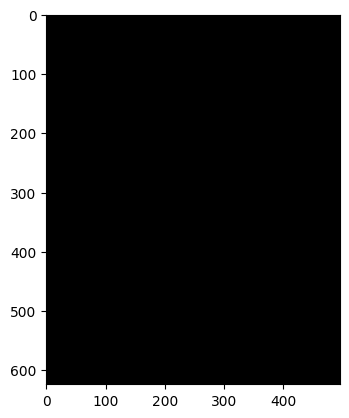

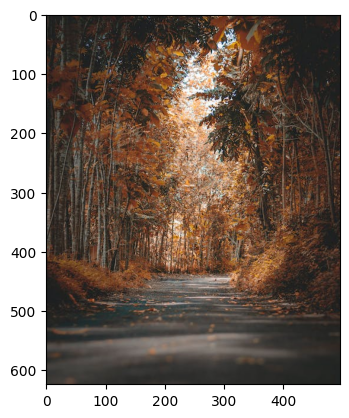

In [9]:
img = cv2.imread('11.jpeg')
img = resize_crop(img)
    
mask1,mask2 = findmask(img, deeplab)

cartoon_img = cartoonize(img, cartoon)

person = cv2.bitwise_and(cartoon_img, cartoon_img, mask=mask1)
background = cv2.bitwise_and(img, img, mask=mask2)
output = person + background
plt.figure(0)
plt.imshow(mask1, cmap='gray')
plt.figure(1)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_RGB2BGR))

In [10]:
end = time.time()
print(end-start)

51.2576847076416


In [17]:
deeplab = rt.InferenceSession('deeplabv3.onnx',providers=['CUDAExecutionProvider'])
cartoon = rt.InferenceSession('cartoonize.onnx',providers=['CUDAExecutionProvider'])

cap = cv2.VideoCapture(0)

while(True):
    ret, frame = cap.read()

    img = resize_crop(frame)
    
    mask1,mask2 = findmask(img, deeplab)

    cartoon_img = cartoonize(img, cartoon)

    person = cv2.bitwise_and(cartoon_img, cartoon_img, mask=mask1)
    background = cv2.bitwise_and(img, img, mask=mask2)
    output = person + background

    cv2.imshow('frame', output)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


In [1]:
from moviepy.editor import VideoFileClip
out_video = VideoFileClip('output_video/utfun1.mp4')
out_audio = VideoFileClip('input_video/utfun1.mp4').audio

output = out_video.set_audio(out_audio)
output.write_videofile('output_video/out.mp4',fps = 23.98)

Moviepy - Building video output_video/out.mp4.
MoviePy - Writing audio in outTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video output_video/out.mp4



Moviepy - Done !
Moviepy - video ready output_video/out.mp4
